In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from scipy.fft import fft

In [2]:
##list of audios

In [4]:
import os

# Specify the directory path
directory = 'audio-n'

# List all files in the directory
file_list = os.listdir(directory)

# Print the list of files
for filename in file_list:
    print(filename)

.ipynb_checkpoints
100..wav
100.wav
110..wav
110.wav
120..wav
120.wav
130..wav
130.wav
140..wav
140.wav
150..wav
150.wav
160..wav
160.wav
170..wav
170.wav
180..wav
180.wav
190..wav
190.wav
200..wav
200.wav
210..wav
210.wav
220..wav
220.wav
230..wav
230.wav
240..wav
240.wav
250..wav
250.wav
260..wav
260.wav
270..wav
270.wav
280..wav
280.wav
290..wav
290.wav
30..wav
30.wav
300..wav
300.wav
40..wav
40.wav
50..wav
50.wav
60..wav
60.wav
70..wav
70.wav
80..wav
80.wav
90..wav
90.wav
vv100.wav
vv101.wav
vv102.wav
vv103.wav
vv104.wav
vv105.wav
vv106.wav
vv107.wav
vv108.wav
vv109.wav
vv110.wav
vv111.wav
vv112.wav
vv55.wav
vv56.wav
vv57.wav
vv58.wav
vv59.wav
vv60.wav
vv61.wav
vv62.wav
vv63.wav
vv64.wav
vv65.wav
vv66.wav
vv67.wav
vv68.wav
vv69.wav
vv70.wav
vv71.wav
vv72.wav
vv73.wav
vv74.wav
vv75.wav
vv76.wav
vv77.wav
vv78.wav
vv79.wav
vv80.wav
vv81.wav
vv82.wav
vv83.wav
vv84.wav
vv85.wav
vv86.wav
vv87.wav
vv88.wav
vv89.wav
vv90.wav
vv91.wav
vv92.wav
vv93.wav
vv94.wav
vv95.wav
vv96.wav
vv97.wav
vv

In [ ]:
##Lbels

In [5]:
import pandas as pd

# Replace 'your_excel_file.xlsx' 
excel_file_path = 'audio-n.xlsx'

# Read the Excel file into a DataFrame
df = pd.read_excel(excel_file_path)
# Extract the 'Diagnosis' column
y = df['ml']

# Print or use the 'Diagnosis' column as needed
print(y)


0      300
1      290
2      280
3      270
4      260
      ... 
109    260
110    270
111    280
112    290
113    300
Name: ml, Length: 114, dtype: int64


# AUTO ML

Version 0.12.1 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.812220515446322

Generation 2 - Current best internal CV score: 0.812220515446322

Generation 3 - Current best internal CV score: 0.812220515446322

Generation 4 - Current best internal CV score: 0.812220515446322

Generation 5 - Current best internal CV score: 0.8231462353820529

Best pipeline: DecisionTreeClassifier(GaussianNB(input_matrix), criterion=gini, max_depth=3, min_samples_leaf=6, min_samples_split=3)
                         Metric      Value
0            F1 Score Train (%)  92.313268
1             F1 Score Test (%)  83.298827
2       Standard Deviation Test   0.499527
3  False Positive Rate Test (%)   0.000000
4  False Negative Rate Test (%)  25.000000


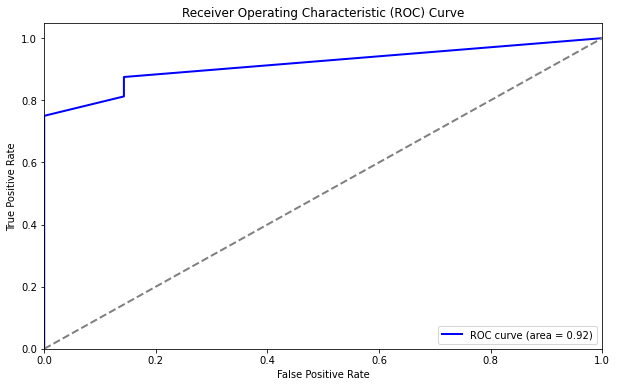

In [12]:
import os
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
import pandas as pd
from tpot import TPOTClassifier
import matplotlib.pyplot as plt

# Define the FFT feature extraction function
def features_extractor_fft_lin_bin(f_vector, fft_us, nbins):
    fmin = 0  # Set fmin to 0 kHz
    fv = np.linspace(fmin, f_vector[len(f_vector) - 1], num=nbins)

    f_vector_bin = []
    for val in fv:
        nf = f_vector[((f_vector > val))]
        if nf.size > 0:
            valf = nf[0]
            f_vector_bin.append(valf)
    f_vector_bin.append(f_vector[len(f_vector) - 1])

    fft_vector_bin = []
    for index in range(len(f_vector_bin) - 1):
        ii = np.where((f_vector >= f_vector_bin[index]) & (f_vector < f_vector_bin[index + 1]))
        fft_values = fft_us[ii]
        feat = np.sum(fft_values)
        fft_vector_bin.append(feat)

    return fft_vector_bin, fv

# Load the Excel file
excel_file_path = 'audio-n.xlsx'
df = pd.read_excel(excel_file_path)

# Define the target variable (binary classification)
# Values equal to or greater than 150 are classified as 1, and values less than 150 are classified as 0
y = (df['ml'] >= 150).astype(int)

# Specify the directory containing audio files
directory = 'audio-n'

# Lists to store features
X = []

# Iterate through audio files in the directory
for audio_file in os.listdir(directory):
    if audio_file.endswith('.wav'):
        audio_file_path = os.path.join(directory, audio_file)
        audio_signal, sr = librosa.load(audio_file_path, sr=96000)
        n_fft = 2048
        f_vector, fft_us = librosa.fft_frequencies(sr=sr, n_fft=n_fft), np.abs(librosa.stft(audio_signal, n_fft=n_fft, dtype=np.complex128))
        nbins = 1000
        fft_feats, freq_bins = features_extractor_fft_lin_bin(f_vector, fft_us, nbins)
        X.append(fft_feats)

X = np.array(X)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=96000)

# Initialize TPOT with reduced number of splits
tpot = TPOTClassifier(verbosity=2, generations=5, population_size=50, random_state=96000, scoring='f1_weighted', cv=3)

# Fit TPOT on training data
tpot.fit(X_train, y_train)

# Predict on the training set
y_train_pred = tpot.predict(X_train)

# Predict on the test set
y_test_pred = tpot.predict(X_test)

# Evaluate the model
f1_train = f1_score(y_train, y_train_pred, average='weighted')
f1_test = f1_score(y_test, y_test_pred, average='weighted')

conf_matrix_test = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = conf_matrix_test.ravel()
fpr_test = fp / (fp + tn)
fnr_test = fn / (fn + tp)

std_dev_test = np.std(y_test_pred)

# Create a DataFrame for the metrics
metrics_df = pd.DataFrame({
    "Metric": ["F1 Score Train (%)", "F1 Score Test (%)", "Standard Deviation Test", "False Positive Rate Test (%)", "False Negative Rate Test (%)"],
    "Value": [f1_train * 100, f1_test * 100, std_dev_test, fpr_test * 100, fnr_test * 100]
})

# Export the best pipeline
tpot.export('best_pipeline.py')

# Display the DataFrame
print(metrics_df)

# Get the predicted probabilities for the positive class
y_test_prob = tpot.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
